# Emotion Recognition from EEG Signals – GAMEEMO Dataset

This notebook demonstrates a **complete baseline pipeline** to train a discrete‐emotion classifier on the [GAMEEMO](https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo) EEG dataset. The goal is to predict the **game‐elicited emotion** category:

* **Boring** (G1)
* **Calm** (G2)
* **Horror** (G3)
* **Funny** (G4)

The dataset is expected to be located in a local `data/` directory adjacent to this notebook (e.g. cloned inside your repository). No internet access or Kaggle API is required.

In [9]:

# !pip install -q kaggle torch torchvision torchaudio scikit-learn seaborn joblib tqdm

import os, re, sys, subprocess, warnings
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.signal import welch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import joblib

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = (
    torch.device('mps') if torch.backends.mps.is_available() else
    torch.device('cuda') if torch.cuda.is_available() else
    torch.device('cpu')
)
print('Running on', device)


Running on mps


## 1 Dataset

In [ ]:

DATA_ROOT = Path('../data/GAMEEMO')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

if not any(DATA_ROOT.rglob('*.csv')):
    print('Downloading GAMEEMO')
    try:
        subprocess.run([
            'kaggle','datasets','download',
            '-d','sigfest/database-for-emotion-recognition-system-gameemo',
            '-p', str(DATA_ROOT.parent),
            '--unzip'
        ], check=True)
    except Exception as e:
        sys.stderr.write(f'⚠️ Kaggle download failed: {e}\n')
else:
    print('Dataset already present – skipping download.')


Dataset URL: https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo
License(s): Attribution 4.0 International (CC BY 4.0)


## 2 File / channel sanity‑check

In [ ]:

# Only pre‑processed EEG CSVs (each file = one emotion run)
csv_files = sorted([p for p in DATA_ROOT.rglob('*.csv')
                    if 'Preprocessed' in p.as_posix() and 'Raw' not in p.as_posix()])
print('Files found:', len(csv_files))

GAME_ID_TO_LABEL = {'G1':'Boring', 'G2':'Calm', 'G3':'Horror', 'G4':'Funny'}
label2idx = {v:i for i,v in enumerate(GAME_ID_TO_LABEL.values())}
idx2label = {i:l for l,i in label2idx.items()}

def label_from_path(p:Path):
    m = re.search(r'G[1-4]', p.stem, re.I)
    if m: return GAME_ID_TO_LABEL[m.group(0).upper()]
    for l in GAME_ID_TO_LABEL.values():
        if l.lower() in p.stem.lower(): return l
    raise ValueError(f'No label for {p}')

# Determine intersection of numeric EEG channels across every CSV
common_cols = None
for fp in csv_files:
    cols = set(pd.read_csv(fp, nrows=1).select_dtypes('number').columns)
    common_cols = cols if common_cols is None else (common_cols & cols)
common_cols = sorted(common_cols)
N_CH = len(common_cols)
print('Shared channels:', N_CH, common_cols)

FS, WIN_SEC = 128, 3                           # GAMEEMO constants
WIN_SAMP = FS * WIN_SEC


Files found: 116
Shared channels: 15 ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8', 'Unnamed: 14']


## 3 Feature helpers

In [ ]:

# ---------- Helper functions ----------------------------------------
def iter_windows(arr, win_len):
    """Yield consecutive, non‑overlapping windows of fixed length."""
    n_win = len(arr)//win_len
    for i in range(n_win):
        yield arr[i*win_len:(i+1)*win_len]

BANDS = {'delta':(1,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}
N_B   = len(BANDS)

def stat_features(windows):
    """Per‑channel mean/std/var/skew/kurt – returned shape (n_win, ch*5)."""
    feats=[]
    for w in windows:
        f=[]
        for ch in range(N_CH):
            x = w[ch]
            f.extend([x.mean(), x.std(), x.var(), skew(x), kurtosis(x)])
        feats.append(f)
    return np.asarray(feats, np.float32)

def band_features(windows):
    """Sum of PSD inside canonical EEG sub‑bands for each channel."""
    feats=[]
    for w in windows:
        row=[]
        for ch in range(N_CH):
            f, p = welch(w[ch], FS, nperseg=WIN_SAMP)
            for lo,hi in BANDS.values():
                row.append(p[(f>=lo)&(f<=hi)].sum())
        feats.append(row)
    return np.asarray(feats, np.float32)

def clean(arr):
    """Replace NaN/Inf with 0, operate in‑place."""
    np.nan_to_num(arr, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    return arr


### 3.1 Build dataset

In [ ]:

stat_all, band_all, raw_all, y_all, groups = [], [], [], [], []

for file_idx, fp in enumerate(tqdm(csv_files, desc='building')):
    label = label_from_path(fp)
    df = pd.read_csv(fp, usecols=common_cols)
    sig = df.to_numpy(np.float32)

    # Channel‑wise z‑score (helps CNN converge)
    sig = (sig - sig.mean(0)) / (sig.std(0)+1e-6)

    # Generate windows
    windows = list(iter_windows(sig, WIN_SAMP))
    if not windows:
        continue
    windows = np.stack(windows)              # (n_win, time, ch)
    windows = windows.transpose(0,2,1)       # (n_win, ch, time) – CNN expects (B,C,T)

    # Hand‑crafted features
    stats = clean(stat_features(windows))
    bands = clean(band_features(windows))

    n_win = len(windows)
    stat_all.append(stats)
    band_all.append(bands)
    raw_all.append(windows)
    y_all.append(np.full(n_win, label2idx[label]))
    groups.extend([file_idx]*n_win)          # file index acts as "group"

X_stat = np.concatenate(stat_all)
X_band = np.concatenate(band_all)
X_raw  = np.concatenate(raw_all)
y      = np.concatenate(y_all)
groups = np.asarray(groups)

X_comb = clean(np.concatenate([X_stat, X_band], 1))

print('Windows total:', len(y))


building: 100%|██████████| 116/116 [01:06<00:00,  1.75it/s]

Windows total: 11484


## 4 Group‑aware train/test split

In [ ]:

# One full CSV per split (no leakage)
gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_SEED)
train_idx, test_idx = next(gss.split(X_stat, y, groups=groups))

idx_train, idx_test = train_idx, test_idx
y_train, y_test = y[idx_train], y[idx_test]

splits = {
    'stat': (X_stat[idx_train], X_stat[idx_test]),
    'comb': (X_comb[idx_train], X_comb[idx_test]),
    'raw' : (X_raw[idx_train],  X_raw[idx_test])
}
print('Train windows:', len(idx_train), '| Test windows:', len(idx_test))

# Helper for confusion matrices
def plot_cm(y_true, y_pred, title):
    labels = [idx2label[i] for i in range(len(idx2label))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    cmn = cm / cm.sum(1, keepdims=True)
    plt.figure(figsize=(4,3))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title); plt.xlabel('Pred'); plt.ylabel('True')
    plt.show()


Train windows: 9108 | Test windows: 2376


## 5 Random Forest

RF accuracy: 73.94781144781145


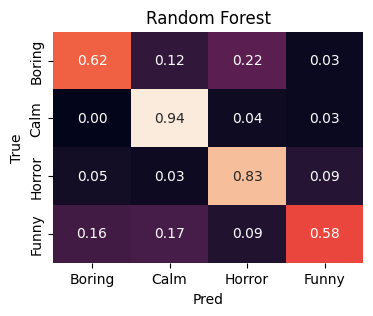

In [ ]:

X_tr, X_te = splits['stat']
rf = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler()),
    ('rf',  RandomForestClassifier(
                n_estimators=400,
                class_weight='balanced',
                n_jobs=-1,
                random_state=RANDOM_SEED))
])
rf.fit(X_tr, y_train)
rf_pred = rf.predict(X_te)
print('RF accuracy:', accuracy_score(y_test, rf_pred)*100)
plot_cm(y_test, rf_pred, 'Random Forest')


## 6 Save

In [ ]:

MODELS_DIR = Path('../models'); MODELS_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(rf, MODELS_DIR/'rf_stat.joblib')
print('Models saved →', MODELS_DIR.resolve())


Models saved → /Users/dromaniv/Repositories/emotion-recognition/models
